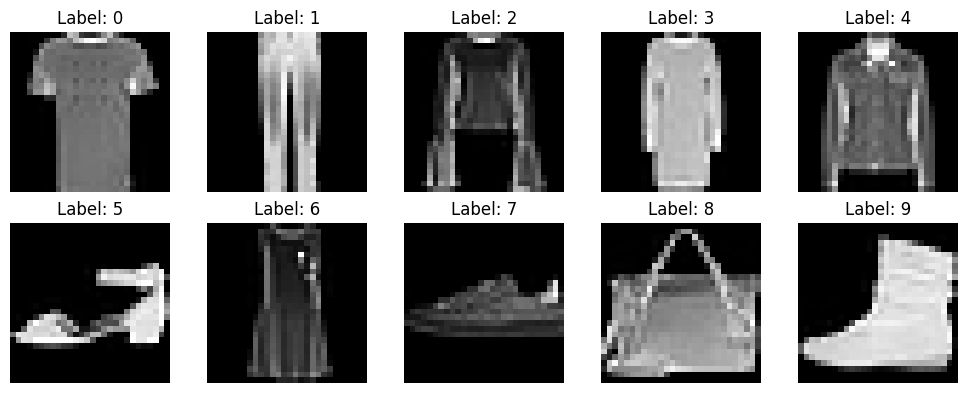

Train Shape: (48000, 784) (48000, 10)
Test Shape: (12000, 784) (12000, 10)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/W0.npy'

In [3]:
# ==========================================
# 📚 Import Libraries
# ==========================================
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 📂 Load Fashion MNIST Dataset (Training)
# ==========================================
df = pd.read_csv("fashion-mnist_train.csv")

# ==========================================
# 🏷️ Split Dataset into Train/Test per Class
# ==========================================
grouped = df.groupby("label")

train_list = []
test_list = []

# For each class, split into 80% train and 20% test
for label, group in grouped:
    train_split, test_split = train_test_split(
        group,
        test_size=0.2,
        random_state=42,
        shuffle=True,
        stratify=None  # Already splitting by label
    )
    train_list.append(train_split)
    test_list.append(test_split)

# Combine all class-wise splits
train_df = pd.concat(train_list).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat(test_list).sample(frac=1, random_state=42).reset_index(drop=True)

# ==========================================
# 🖼️ Display One Example per Class
# ==========================================
examples = train_df.groupby("label").first().reset_index()

plt.figure(figsize=(10, 4))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    img = examples.loc[i].drop("label").values.astype(np.uint8).reshape(28, 28)
    plt.imshow(img, cmap="gray")
    plt.title(f"Label: {examples.loc[i, 'label']}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# ==========================================
# 🏗️ Prepare Data Matrices and One-Hot Labels
# ==========================================
X = train_df.drop("label", axis=1).values.astype(np.float32)
y = train_df["label"].values
num_classes = np.max(y) + 1
y = np.eye(num_classes)[y]  # One-hot encoding

X_test = test_df.drop("label", axis=1).values.astype(np.float32)
y_test = test_df["label"].values
y_test = np.eye(num_classes)[y_test]

# ==========================================
# 🔄 Standardize Features (Zero Mean, Unit Var)
# ==========================================
np.random.seed(0)

mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std
X_test = (X_test - mean) / std

print("Train Shape:", X.shape, y.shape)
print("Test Shape:", X_test.shape, y_test.shape)

# ==========================================
# 🧮 Define Activation Functions
# ==========================================
def relu(x, grad):
    """ReLU activation and gradient."""
    if grad:
        return (x > 0).astype(float)
    return np.maximum(0, x)

def sigmoid(x, grad):
    """Sigmoid activation and gradient."""
    s = 1 / (1 + np.exp(-x))
    if grad:
        return s * (1 - s)
    return s

def softmax(z, grad):
    """Softmax activation (no gradient here)."""
    exps = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

# ==========================================
# 🧠 Neural Network Architecture
# ==========================================
arch = [300, 400, 10]
activations = [relu, relu, softmax]

# Initialize weights and biases
W = []
B = []
for i in range(len(arch)):
    if i == 0:
        w = np.random.randn(X.shape[1], arch[i]) * np.sqrt(2. / X.shape[1])
    else:
        w = np.random.randn(arch[i-1], arch[i]) * np.sqrt(2. / arch[i-1])
    b = np.zeros((1, arch[i]))
    W.append(w)
    B.append(b)

# ==========================================
# 🏋️ Training Parameters
# ==========================================
alpha = 0.002
batch_size = 32
epochs = 600
best_test_acc = 0

# Tracking metrics
train_acc_history = []
test_acc_history = []
train_cost_history = []
test_cost_history = []

# ==========================================
# 🚀 Training Loop
# ==========================================
for epoch in range(epochs):
    batch_acc = []
    batch_cost = []
    
    # Mini-batch gradient descent
    for i in range(int(np.ceil(len(X) / batch_size))):
        X_batch = X[i * batch_size : (i + 1) * batch_size]
        y_batch = y[i * batch_size : (i + 1) * batch_size]

        # Forward pass
        A = X_batch
        all_A = []
        all_Z = []
        for l in range(len(W)):
            Z = A @ W[l] + B[l]
            A = activations[l](Z, grad=False)
            all_Z.append(Z)
            all_A.append(A)

        # Compute cost
        m = X_batch.shape[0]
        cost = -np.sum(y_batch * np.log(A + 1e-8)) / m
        batch_cost.append(cost)

        # Compute accuracy
        pred_labels = np.argmax(A, axis=1)
        true_labels = np.argmax(y_batch, axis=1)
        acc = np.mean(pred_labels == true_labels) * 100
        batch_acc.append(acc)

        # Backward pass
        dz = A - y_batch
        for l in reversed(range(len(W))):
            if l < len(W) - 1:
                dz = (dz @ W[l + 1].T) * activations[l](all_Z[l], grad=True)
            dw = (all_A[l-1].T @ dz) if l > 0 else (X_batch.T @ dz)
            db = np.sum(dz, axis=0, keepdims=True)
            W[l] -= (alpha / m) * dw
            B[l] -= (alpha / m) * db

    # Evaluate on test set
    test_acc = []
    test_cost = []
    for i in range(int(np.ceil(len(X_test) / batch_size))):
        X_batch = X_test[i * batch_size : (i + 1) * batch_size]
        y_batch = y_test[i * batch_size : (i + 1) * batch_size]
        A = X_batch
        for l in range(len(W)):
            Z = A @ W[l] + B[l]
            A = activations[l](Z, grad=False)
        m_test = X_batch.shape[0]
        cost = -np.sum(y_batch * np.log(A + 1e-8)) / m_test
        test_cost.append(cost)
        pred_labels = np.argmax(A, axis=1)
        true_labels = np.argmax(y_batch, axis=1)
        acc = np.mean(pred_labels == true_labels) * 100
        test_acc.append(acc)

    # Track epoch metrics
    train_acc_history.append(np.mean(batch_acc))
    test_acc_history.append(np.mean(test_acc))
    train_cost_history.append(np.mean(batch_cost))
    test_cost_history.append(np.mean(test_cost))

    # Save best model
    if np.mean(test_acc) > best_test_acc:
        best_test_acc = np.mean(test_acc)
        for k in range(len(W)):
            np.save(f"/kaggle/working/W{k}.npy", W[k])
            np.save(f"/kaggle/working/B{k}.npy", B[k])

    print(
        f"Epoch {epoch} | Train Acc: {np.mean(batch_acc):.2f}% | Test Acc: {np.mean(test_acc):.2f}% | "
        f"Train Cost: {np.mean(batch_cost):.4f} | Test Cost: {np.mean(test_cost):.4f} | Best Test Acc: {best_test_acc:.2f}%"
    )

# ==========================================
# 🧪 Evaluation on Separate Test Data
# ==========================================
df_test = pd.read_csv("fashion-mnist_test.csv")

# Load best saved weights
W = [np.load(f"/kaggle/working/W{k}.npy") for k in range(3)]
B = [np.load(f"/kaggle/working/B{k}.npy") for k in range(3)]

X_eval = df_test.drop("label", axis=1).values.astype(np.float32)
y_eval = df_test["label"].values
y_eval = np.eye(num_classes)[y_eval]

X_eval = (X_eval - mean) / std

# Evaluate
eval_cost = []
eval_acc = []
for i in range(int(np.ceil(len(X_eval) / batch_size))):
    X_batch = X_eval[i * batch_size : (i + 1) * batch_size]
    y_batch = y_eval[i * batch_size : (i + 1) * batch_size]
    A = X_batch
    for l in range(len(W)):
        Z = A @ W[l] + B[l]
        A = activations[l](Z, grad=False)
    m = X_batch.shape[0]
    cost = -np.sum(y_batch * np.log(A + 1e-8)) / m
    eval_cost.append(cost)
    pred_labels = np.argmax(A, axis=1)
    true_labels = np.argmax(y_batch, axis=1)
    acc = np.mean(pred_labels == true_labels) * 100
    eval_acc.append(acc)

print(f"Evaluation Cost: {np.mean(eval_cost):.4f} | Accuracy: {np.mean(eval_acc):.2f}%")
